In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [7]:
mc_data = pd.read_json('../../datasets/SciFi_200000_Clean_TrackStudy.json')
#real_data = pd.read_json('../../datasets/SciFi_200000_AllHits.json')

In [8]:
###### Data columns
i = 0
print('\n Clean TrackStudy Dataset:\n')
for val in mc_data.columns:
    print(i," ",val)
    i = i + 1
print('\n AllHits Dataset:\n')
# Data columns
i = 0
for val in real_data.columns:
    print(i," ",val)
    i = i + 1


 Clean TrackStudy Dataset:

0   MCParticleID
1   MC_Hit_X
2   MC_Hit_Y
3   MC_Hit_Z
4   PrHit_LHCbID
5   PrHit_Xat0
6   PrHit_Zat0
7   PrHit_isX
8   PrHit_planeCode
9   PrHit_w2
10   PrHit_yMax
11   PrHit_yMin
12   PrHit_zone
13   event

 AllHits Dataset:



NameError: name 'real_data' is not defined

In [9]:
mc_hits = mc_data.values
#real_hits = real_data.values

In [10]:
zLays = [7825.99951172, 7895.99951172, 7966.        , 8036.00048828,
       8507.99902344, 8577.99902344, 8647.99902344, 8718.00097656,
       9192.99902344, 9262.99902344, 9332.99902344, 9403.00097656]

max_x = 3182.8356933594
min_x = -3182.8576660156
min_y = -2438.6506347656
max_y = 2438.6506347656

In [11]:
# Create X and Y matrices for the future model
length = mc_hits.shape[0]

X = np.zeros((length, 1))
Y = np.zeros((length, 11))

i = 0
empty_particles = []
for i in range(0,length):
    
    if ((len(mc_hits[i][5]) > 1)):
        # Get the first element of the hit, in the first layer
        X[i] = mc_hits[i][5][0]
        
        # Get only the first element if there are several repeated with small differences
        j = 0
        extra_hits = mc_hits[i][5]
        try:
            while (np.abs(extra_hits[j] - extra_hits[j + 1]) < 5):
                j += 1
            j += 1
        except IndexError as e:
            X[i] = np.zeros(1)
            continue
        
        # Get all hits from the given particle which are not located in the first layer
        extra_hits = mc_hits[i][5][j:]
        actual_pos = 0
        j = 0
        try:
            while (j < len(extra_hits)):
                Y[i][actual_pos] = extra_hits[j]
                # Same as above, get only the first element in case there are several hits with similar X position
                while (j + 1 < len(extra_hits) and np.abs(extra_hits[j] - extra_hits[j + 1]) < 3):
                    j += 1
                actual_pos += 1
                j += 1
        except IndexError:
            X[i] = np.zeros(1)
            Y[i] = np.zeros(11)

In [12]:
# Removing empty values, as some hits in the mc_hits dataset do not contain readings (PrHit...)
Y = Y[Y[:,0] != 0]
X = X[X[:,0] != 0]

In [47]:
def showTracksMCHits(electrons, elev, angle, max, alpha):
    
    fig = plt.figure(figsize=(19, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    if alpha != 0:
        xs = np.linspace(min_x, max_x)
        ys = np.linspace(min_y, max_y)
        X_tmp, Z_tmp = np.meshgrid(xs, ys)

        for layer in zLays:
            ax.plot_surface(X_tmp, layer, Z_tmp, alpha=alpha)
    
    
    # Ensure that the next plot doesn't overwrite the first plot
    ax = plt.gca()
    
    X = []
    Z = []
    Y = []
    
    # Iterate through all the particles keys obtained 
    for particle in mc_hits[:max]:
        
        if (particle[0] == 11) and (particle[0] == -11):
            continue
        
        if (len(particle[1]) > 1):
            X = np.array(particle[1]).astype(float)
            Y = np.array(particle[2]).astype(float)
            Z = np.array(particle[3]).astype(float)
            ax.plot(X, Z, Y)

    ax.view_init(elev=elev, azim=angle)
    ax.grid()
    #ax.set_xlabel('\n\nX position')
    ax.set_ylabel('\n\n\nZ position')
    ax.set_xticks([])
    ax.set_zlabel('Y position')
    
    plt.show()

In [48]:
def showPredictedTracks(min, max, event):
    
    fig = plt.figure(figsize=(19, 8))
    ax = fig.add_subplot(111)
    
    lay = 0
    for layer in zLays:
        X_tmp = [min_x, max_x]
        Y_tmp = [layer, layer]
        if (lay == 0):
            ax.plot(X_tmp, Y_tmp, '--', c='green', label='X layers', linewidth=1, alpha=0.4)
        elif lay == 3 or lay == 4 or lay == 7 or lay == 8 or lay == 11:
            ax.plot(X_tmp, Y_tmp, '--', c='green', linewidth=1, alpha=0.4)
        elif (lay == 2):
            ax.plot(X_tmp, Y_tmp, '--', c='blue', label='V layers', linewidth=1, alpha=0.4)
        elif (lay % 2 == 0):
            ax.plot(X_tmp, Y_tmp, '--', c='blue', linewidth=1, alpha=0.4)
        elif (lay == 1):
            ax.plot(X_tmp, Y_tmp, '--', c='red', label='U layers', linewidth=1, alpha=0.4)
        else:
            ax.plot(X_tmp, Y_tmp, '--', c='red', linewidth=1, alpha=0.4)
            
        lay += 1
    
    hits = mc_hits[:100]
    
    # Iterate through all the particles keys obtained 
    for i in range(0,100):
        if (len(hits[i][5]) == 0):
            continue
        X = np.array(hits[i][1]).astype(float)
        Y = np.array(hits[i][3]).astype(float)
        ax.plot(X, Y)
        
        first = hits[i][5][0]
        m = (first) / (zLays[0] - 250)
        pred = m * zLays[3]
        
        X = np.array([first, pred])
        Y = np.array([zLays[0], zLays[3]])
        #ax.text(first + 10, zLays[0] + 240, 'Prediction', fontsize=12)
        #ax.plot(X, Y)
        
        first = hits[i][5][4]
        m = (first) / (zLays[4] - 400)
        pred = m * zLays[7]
        
        X = np.array([first, pred])
        Y = np.array([zLays[4], zLays[7]])
        #ax.text(first + 10, zLays[0] + 240, 'Prediction', fontsize=12)
        #ax.plot(X, Y)
        
            
    leg = plt.legend(loc=0, prop={'size': 16})
    leg_lines = leg.get_lines()
    leg_texts = leg.get_texts()
    plt.setp(leg_lines, linewidth=1, alpha=1)
    plt.setp(leg_texts, fontsize='x-large')
    ax.set_xlabel('X position')
    ax.set_ylabel('Z position')
    leg.get_frame().set_alpha(1)
    plt.show()

In [49]:
def removeSimilar(array, max):
    clean = np.zeros(max)
    j = 0
    actual_pos = 0
    while (j < len(array)):
        clean[actual_pos] = array[j]
        while (j + 1 < len(array) and np.abs(array[j] - array[j + 1]) < 3):
            j += 1
        actual_pos += 1
        j += 1
    return clean

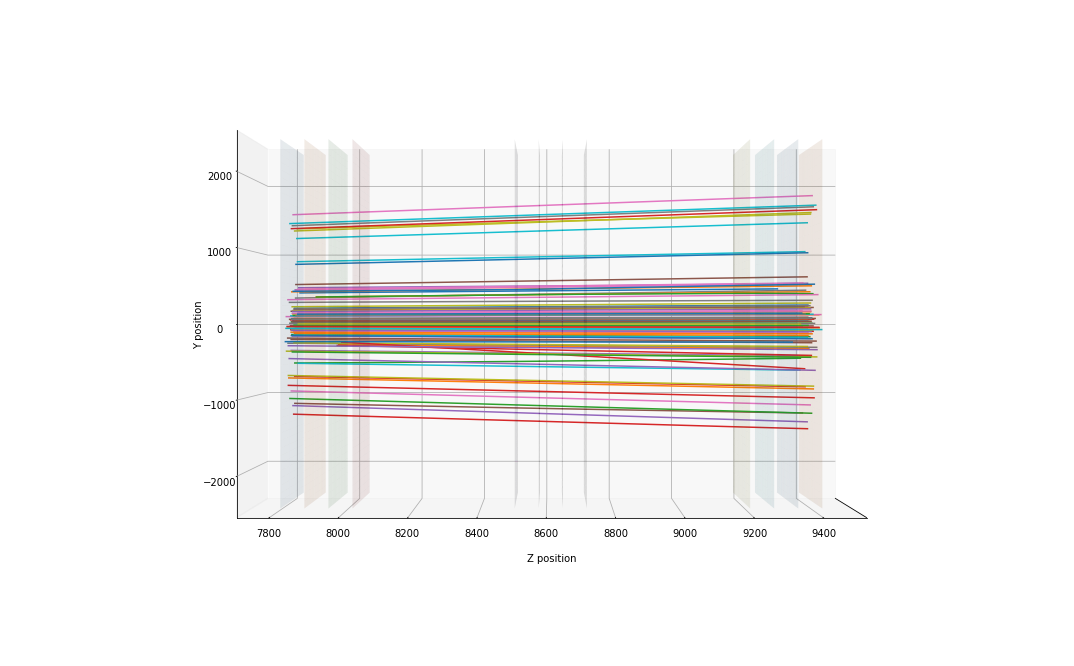

In [50]:
showTracksMCHits(True, 0, 0, 100, 0.1)

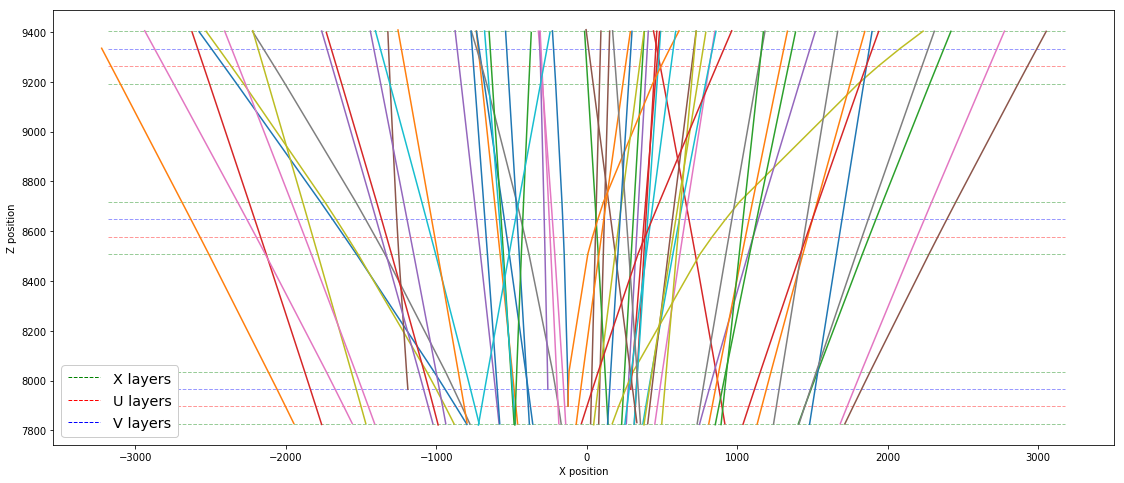

In [270]:
showPredictedTracks(0,100, 22336)

In [19]:
def showPredictedAndReal(min, max):
    
    if min < 0:
        min = max - 1
    
    fig = plt.figure(figsize=(19, 8))
    ax = fig.add_subplot(111)
    
    # Iterate through all the particles keys obtained 
    for i in range(min,max):
        X = np.array(mc_hits[i][1]).astype(float)
        Y = np.array(mc_hits[i][3]).astype(float)
        ax.plot(X, Y)
        textPos_X = X[int(len(X) / 2)]
        textPos_Y = Y[int(len(Y) / 2)]
        X = np.array(mc_hits[i][5]).astype(float)
        Y = np.array(mc_hits[i][6]).astype(float)
        ax.plot(X, Y)
        if (len(X) == 0):
            ax.text(textPos_X + 10, textPos_Y, 'No prediction', fontsize=12)
            
    ax.grid()
    plt.show()

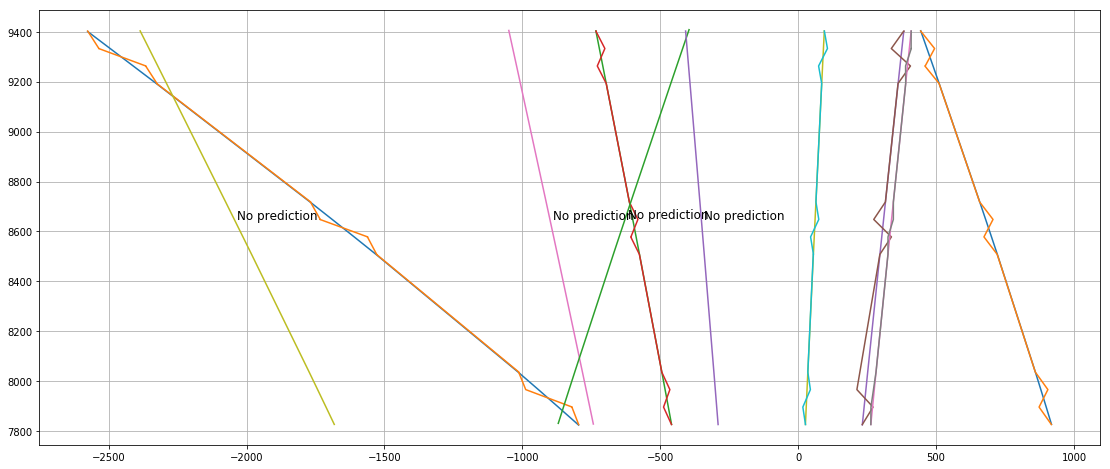

In [20]:
showPredictedAndReal(0,10)